In [1]:
import os
import pandas as pd
import random
import csv
import numpy as np
import json

In [72]:
root = '/media/visiopharm5/WDGold/deeplearning/Hepatocarcinomes'

## Reference

In [3]:
# Load the reference file linking mRNA ID and slide ID
ref = pd.read_csv(os.path.join(root, 'TCGA/data/HMN.csv'), sep = ';')
print(ref.shape) # (208, 2)
display(ref.head(5))

(208, 2)


,Tumor_ID,Nanostring_id
0,HMNT0278,EX128-ARN002
1,HMNT0670,EX128-ARN004
2,HMNT0701,EX128-ARN006
3,HMNT0628,EX128-ARN010
4,HMNT0519,EX128-ARN012


## Mondor mRNA data

### Data visualization and exception analysis

In [4]:
# Load mRNA data of Mondor series
df = pd.read_csv(os.path.join(root, 'TCGA/data/nanostring_mondor/EX128_normadata_b08-b09_b10-060720-sans313.txt'), 
                 sep = '\t')
display(df.head(5))
print(df.shape) # (786, 161)

,Probe Name,Annotation,Class Name,EX128-ARN189,EX128-ARN190,EX128-ARN191,EX128-ARN192,EX128-ARN193,EX128-ARN194,EX128-ARN195,...,EX128-ARN338,EX128-ARN339,EX128-ARN340,EX128-ARN341,EX128-ARN342,EX128-ARN343,EX128-ARN344,EX128-ARN345,EX128-ARN346,EX128-ARN347
0,NaN,NaN,NaN,P743821,P734242,P719664,P701988,P701701,P699574,P699553,...,P622582,P621115,P619428,P613079,P607163,P606883,MAQC human,P606307,P605714,P605285
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A2M,NaN,Endogenous,4301.22,17983.246,15483.546,5113.288,4250.48,22340.941,7798.648,...,8090.045,10301.013,14885.443,40962.395,3889.948,18862.059,1442.44,6113.576,30052.156,19756.762
3,ACVR1C,NaN,Endogenous,35.049,20.447,34.268,157.602,206.357,99.563,39.143,...,82.297,92.323,239.394,40.155,86.482,53.972,3.636,21.423,120.063,29.988
4,ADAM12,NaN,Endogenous,9.6,111.335,1,2.646,1.291,8.33,7.946,...,2.08,29.2,3.53,19.692,4.129,5.168,110.465,8.054,11.779,5.56


(786, 161)


#### Row Exception

In [5]:
# Row Class Name
{anno for anno in df["Class Name"] if str(anno) != 'nan'}

{'Endogenous', 'Housekeeping', 'Negative', 'Positive'}

In [6]:
# The column "Annotation" only contains NaN, thus no useful info
for anno in df["Annotation"]:
    if str(anno) != 'nan':
        print(anno) # 0

In [7]:
df[df["Class Name"]=='Housekeeping']["Probe Name"] # 20

752       ABCF1
753     DNAJC14
754       ERCC3
755        G6PD
756        GUSB
757      MRPL19
758       NRDE2
759        OAZ1
760      POLR2A
761       PSMC4
762        PUM1
763        SDHA
764       SF3A1
765     STK11IP
766    TBC1D10B
767         TBP
768        TFRC
769        TLK2
770       TMUB2
771         UBB
Name: Probe Name, dtype: object

In [8]:
df[df["Class Name"]=='Negative']["Probe Name"] # 8

772    NEG_A
773    NEG_B
774    NEG_C
775    NEG_D
776    NEG_E
777    NEG_F
778    NEG_G
779    NEG_H
Name: Probe Name, dtype: object

In [9]:
df[df["Class Name"]=='Positive']["Probe Name"] # 6

780    POS_A
781    POS_B
782    POS_C
783    POS_D
784    POS_E
785    POS_F
Name: Probe Name, dtype: object

#### Column Exception

In [10]:
list_other_samples = []
for i in list(df.iloc[0,:]):
    if len(str(i))!=7 or not i.startswith("P"):
        list_other_samples.append(i)
print(list_other_samples) # 11, MAQC is The MicroArray Quality Control
df.loc[:, df.iloc[0,:].isin(list_other_samples)] # Attention here lacking the column "Annotation"

[nan, nan, nan, 'MAQC human', 'H2O', 'P764429 B03', 'P764429 C07', 'P761250 A02', 'P761250 B02', 'P761250 C02', 'MAQC human']


,Probe Name,Class Name,EX128-ARN271,EX128-ARN272,EX128-ARN309,EX128-ARN310,EX128-ARN324,EX128-ARN325,EX128-ARN326,EX128-ARN344
0,NaN,NaN,MAQC human,H2O,P764429 B03,P764429 C07,P761250 A02,P761250 B02,P761250 C02,MAQC human
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A2M,Endogenous,1887.54,1,15140.82,12990.333,26079.98,26096.658,7459.269,1442.44
3,ACVR1C,Endogenous,2.614,1,106.589,83.424,141.57,10.167,206.471,3.636
4,ADAM12,Endogenous,146.376,1,14.94,7.726,4.037,56.455,3.141,110.465
...,...,...,...,...,...,...,...,...,...,...
781,POS_B,Positive,5474,5063,8261,7825,7013,7986,7244,7750
782,POS_C,Positive,1511,1404,2325,2186,2048,2173,2013,2109
783,POS_D,Positive,315,311,572,554,491,482,472,465
784,POS_E,Positive,34,39,81,68,57,70,56,69


In [11]:
for i in df.iloc[1, :]:
    if str(i) != 'nan':
        print(i) # FLAG

FLAG


In [12]:
df.loc[:, df.iloc[1, :] == "FLAG"]

,EX128-ARN321
0,P672772
1,FLAG
2,41107.309
3,1.833
4,12.615
...,...
781,4937
782,1415
783,394
784,54


In [13]:
df.drop(columns=["EX128-ARN271", "EX128-ARN272", "EX128-ARN344"], inplace = True) # drop 2 MAQC human and 1 H2O

In [14]:
list_mrna_id = df.columns[3:].values.tolist()
print(len(list_mrna_id)) # 155. checked unique
print(list_mrna_id[:3])

155
['EX128-ARN189', 'EX128-ARN190', 'EX128-ARN191']


In [15]:
# List the cases with mRNA data but not in the reference
set_cases_mrna_not_in_ref = set(list_mrna_id) - set(ref['Nanostring_id'].tolist())
print(len(set_cases_mrna_not_in_ref)) # 4
display(set_cases_mrna_not_in_ref) # 'EX128-ARN195', 'EX128-ARN200', 'EX128-ARN209', 'EX128-ARN212'

4


{'EX128-ARN195', 'EX128-ARN200', 'EX128-ARN209', 'EX128-ARN212'}

In [16]:
df[list(set_cases_mrna_not_in_ref)] # Checked none of the ID starting with P (included and not) is included in the slide ID

,EX128-ARN209,EX128-ARN195,EX128-ARN200,EX128-ARN212
0,P689765,P699553,P695739,P681778
1,NaN,NaN,NaN,NaN
2,24158.225,7798.648,2465.206,15466.154
3,61.799,39.143,199.261,79.401
4,23.795,7.946,1.933,1
...,...,...,...,...
781,9492,10130,12153,9521
782,2674,2804,3379,2632
783,706,773,907,704
784,113,150,164,105


In [92]:
df_cases_mrna_not_in_ref = pd.DataFrame(set_cases_mrna_not_in_ref, columns=["mrna_id"])
df_cases_mrna_not_in_ref.to_csv(os.path.join(root, 'TCGA/data/HMN_HCC_mrna_not_in_ref.csv'), index=False)

In [17]:
# Subset the reference with mRNA
ref_with_mrna = ref[ref['Nanostring_id'].isin(list_mrna_id)]

print(ref_with_mrna.shape) # (151, 2)
ref_with_mrna

(151, 2)


,Tumor_ID,Nanostring_id
20,HMNT2247,EX128-ARN189
21,HMNT2066,EX128-ARN190
22,HMNT1938,EX128-ARN191
23,HMNT1749,EX128-ARN192
24,HMNT1745,EX128-ARN193
...,...,...
167,HMNT0502,EX128-ARN342
168,HMNT0500,EX128-ARN343
169,HMNT0727,EX128-ARN345
170,HMNT0504,EX128-ARN346


## Slide list

In [18]:
# List all the HCC slides of Mondor series
path_slides = os.path.join(root, 'slides_annotations_hammamatsu')

list_slides = []
for roots, dirs, files in os.walk(path_slides):
    for file in files:
        if file.endswith('.ndpi') or file.endswith('.svs'):
            list_slides.append(file)
            
print(len(list_slides)) # 756
print(list_slides[:3])

756
['HMNT0001.ndpi', 'HMNT0001_bis - 2017-05-31 15.03.09.ndpi', 'HMNT0003 - 2017-05-29 15.41.33.ndpi']


In [105]:
# # Slides added at 10/01/2021
# for roots, dirs, files in os.walk('/home/visiopharm5/Downloads/Missing slides'):
#     for file in files:
#         if file.endswith('.ndpi') or file.endswith('.svs'):
#             print(file) # 11
#             list_slides.append(file)
            
# print(len(list_slides)) # 758

HMNT2386_P761529-C01-HES.svs
HMNT2410_P764429_C06_HE - 2020-07-23 16.13.36.ndpi
HMNT2387_P761471-A03-HES.svs
HMNT0472_P672772_03 - 2019-11-05 01.18.44.ndpi
HMNT2409_P764429_B01_HE - 2020-07-23 16.26.41.ndpi
HMNT2326_P758321-B04-HES.svs
HMNT1781_P705474_01_HES - 2018-11-01 10.08.24.ndpi
HMNT1885_P703089_B02_HES - 2018-11-01 09.22.15.ndpi
HMNT2066_P734242_01_HES - 2018-11-01 16.13.44.ndpi
HMNT2321_757692-05-HES.svs
HMNT0516_P622582-05-HES.svs
758


In [19]:
# List Mondor HCC cases
set_cases = {slide[:8] for slide in list_slides} # extract case ID

print(len(set_cases)) # 406
print(random.sample(set_cases, 3))

406
['HMNT0332', 'HMNT0611', 'HMNT0536']


### 1 Extract case with no slides but with mRNA

In [20]:
ref_with_mrna['Tumor_ID'].shape

(151,)

In [21]:
ref_with_mrna[ref_with_mrna['Tumor_ID'].isna()] # EX128-ARN302

,Tumor_ID,Nanostring_id
127,NaN,EX128-ARN302


In [48]:
# Find the case ID of missing slides but with mRNA data
set_mrna_missing = set(ref_with_mrna['Tumor_ID']) - set_cases
print(len(set_mrna_missing)) # 12
display(set_mrna_missing)

12


{'HMNT0447',
 'HMNT0558',
 'HMNT1326',
 'HMNT1938',
 'HMNT2247',
 'HMNT2311',
 'HMNT2327',
 'HMNT2365',
 'HMNT2381',
 'HMNT2382',
 'HMNT2384',
 nan}

In [50]:
df['EX128-ARN302'] # checked P538053 (with P included and not) not included in any slide ID

0       P538053
1           NaN
2      7473.301
3         8.417
4        31.065
         ...   
781       10612
782        2829
783         721
784         101
785          61
Name: EX128-ARN302, Length: 786, dtype: object

In [49]:
# Subset the reference with cases of slides missing
ref_mrna_no_slide = ref_with_mrna[ref_with_mrna['Tumor_ID'].isin(set_mrna_missing)]

print(ref_mrna_no_slide.shape) # (12, 2)
ref_mrna_no_slide

(12, 2)


,Tumor_ID,Nanostring_id
20,HMNT2247,EX128-ARN189
22,HMNT1938,EX128-ARN191
109,HMNT0447,EX128-ARN284
127,NaN,EX128-ARN302
136,HMNT1326,EX128-ARN311
139,HMNT0558,EX128-ARN314
149,HMNT2381,EX128-ARN324
150,HMNT2382,EX128-ARN325
151,HMNT2384,EX128-ARN326
152,HMNT2365,EX128-ARN327


In [24]:
# Export the subset reference
ref_mrna_no_slide.to_csv(os.path.join(root, 'TCGA/data/HMN_HCC_mrna_no_slide.csv'))

### Export ref linking from mRNA ID to slide (and case ID)

In [60]:
ref_with_mrna_slides = ref_with_mrna.drop(ref_mrna_no_slide.index)
print(ref_with_mrna_slides .shape)
display(ref_with_mrna_slides.head(5))

(139, 2)


,Tumor_ID,Nanostring_id
21,HMNT2066,EX128-ARN190
23,HMNT1749,EX128-ARN192
24,HMNT1745,EX128-ARN193
25,HMNT1688,EX128-ARN194
26,HMNT1750,EX128-ARN196


In [65]:
df_slides = pd.DataFrame(list_slides, columns=['slide_name'])
df_slides['slide_id'] = ''
df_slides['case_id'] = ''
for i in range(df_slides.shape[0]):
    df_slides.iloc[i, 1] = df_slides.iloc[i, 0].split('.ndpi')[0].split('.svs')[0]
    df_slides.iloc[i, 2] = df_slides.iloc[i, 0][:8]
print(df_slides .shape)
display(df_slides.head(5))

(756, 3)


,slide_name,slide_id,case_id
0,HMNT0001.ndpi,HMNT0001,HMNT0001
1,HMNT0001_bis - 2017-05-31 15.03.09.ndpi,HMNT0001_bis - 2017-05-31 15.03.09,HMNT0001
2,HMNT0003 - 2017-05-29 15.41.33.ndpi,HMNT0003 - 2017-05-29 15.41.33,HMNT0003
3,HMNT0003_bis.ndpi,HMNT0003_bis,HMNT0003
4,HMNT0004 - 2017-07-08 21.07.19.ndpi,HMNT0004 - 2017-07-08 21.07.19,HMNT0004


In [70]:
ref_mrna2slides = pd.merge(ref_with_mrna_slides, df_slides, left_on="Tumor_ID", right_on="case_id", how="inner")
print(ref_mrna2slides.shape)
display(ref_mrna2slides.head(5))

(260, 5)


,Tumor_ID,Nanostring_id,slide_name,slide_id,case_id
0,HMNT2066,EX128-ARN190,HMNT2066_P734242_01_HES - 2018-11-01 16.13.44....,HMNT2066_P734242_01_HES - 2018-11-01 16.13.44,HMNT2066
1,HMNT1749,EX128-ARN192,HMNT1749 - 2017-07-08 09.31.45.ndpi,HMNT1749 - 2017-07-08 09.31.45,HMNT1749
2,HMNT1749,EX128-ARN192,HMNT1749_bis - 2017-07-08 10.18.44.ndpi,HMNT1749_bis - 2017-07-08 10.18.44,HMNT1749
3,HMNT1745,EX128-ARN193,HMNT1745_bis - 2017-07-08 07.08.06.ndpi,HMNT1745_bis - 2017-07-08 07.08.06,HMNT1745
4,HMNT1745,EX128-ARN193,HMNT1745 - 2017-07-08 06.39.46.ndpi,HMNT1745 - 2017-07-08 06.39.46,HMNT1745


In [77]:
ref_mrna2slides.drop(columns="Tumor_ID", inplace=True)
print(ref_mrna2slides.shape)
display(ref_mrna2slides.head(5))

(260, 4)


,Nanostring_id,slide_name,slide_id,case_id
0,EX128-ARN190,HMNT2066_P734242_01_HES - 2018-11-01 16.13.44....,HMNT2066_P734242_01_HES - 2018-11-01 16.13.44,HMNT2066
1,EX128-ARN192,HMNT1749 - 2017-07-08 09.31.45.ndpi,HMNT1749 - 2017-07-08 09.31.45,HMNT1749
2,EX128-ARN192,HMNT1749_bis - 2017-07-08 10.18.44.ndpi,HMNT1749_bis - 2017-07-08 10.18.44,HMNT1749
3,EX128-ARN193,HMNT1745_bis - 2017-07-08 07.08.06.ndpi,HMNT1745_bis - 2017-07-08 07.08.06,HMNT1745
4,EX128-ARN193,HMNT1745 - 2017-07-08 06.39.46.ndpi,HMNT1745 - 2017-07-08 06.39.46,HMNT1745


In [78]:
ref_mrna2slides.to_csv(os.path.join(root, 'TCGA/data/reference_mrna2slides.csv'))

### 2 Cases with no slides (with or without mRNA)

In [25]:
# Find the case ID of missing slides (including those case we don't have mRNA)
set_missing = set(ref['Tumor_ID']) - set_cases
print(len(set_missing)) # 19
display(set_missing)

19


{'HMNT0447',
 'HMNT0558',
 'HMNT0678',
 'HMNT1326',
 'HMNT1704',
 'HMNT1765',
 'HMNT1775',
 'HMNT1779',
 'HMNT1791',
 'HMNT1938',
 'HMNT2051',
 'HMNT2247',
 'HMNT2311',
 'HMNT2327',
 'HMNT2365',
 'HMNT2381',
 'HMNT2382',
 'HMNT2384',
 nan}

In [26]:
# Subset the reference with cases of slides missing
ref_no_slide = ref[ref['Tumor_ID'].isin(set_missing)]

print(ref_no_slide.shape) # (55, 2)
ref_no_slide

(55, 2)


,Tumor_ID,Nanostring_id
8,HMNT2051,EX128-ARN020
9,HMNT0678,EX128-ARN024
12,HMNT1704,EX128-ARN032
16,HMNT1779,EX128-ARN040
17,HMNT1775,EX128-ARN042
18,HMNT1791,EX128-ARN044
19,HMNT1765,EX128-ARN048
20,HMNT2247,EX128-ARN189
22,HMNT1938,EX128-ARN191
109,HMNT0447,EX128-ARN284


In [27]:
# Export the subset reference
ref_no_slide.to_csv(os.path.join(root, 'TCGA/data/HMN_HCC_no_slide.csv'))

## Extract the slides (and path) with mRNA for QuPath importation

In [28]:
set_cases_mrna = set(ref_with_mrna['Tumor_ID'].values.tolist()) - set_mrna_missing
print(len(set_cases_mrna))

list_slides_mrna = [s for s in list_slides if s[:8] in set_cases_mrna]
print(len(list_slides_mrna))
list_slides_mrna[:3]

139
260


['HMNT0071 - 2017-06-15 11.35.00.ndpi',
 'HMNT0071_bis - 2017-06-15 12.25.18.ndpi',
 'HMNT0073 - 2017-06-17 21.44.27.ndpi']

In [29]:
# Complete slide name into absolute path
list_path_slides_mrna = [os.path.join(root, 'slides_annotations_hammamatsu', s) for s in list_slides_mrna]
print(len(list_path_slides_mrna))
list_path_slides_mrna[:3]

260


['/media/visiopharm5/WDGold/deeplearning/Hepatocarcinomes/slides_annotations_hammamatsu/HMNT0071 - 2017-06-15 11.35.00.ndpi',
 '/media/visiopharm5/WDGold/deeplearning/Hepatocarcinomes/slides_annotations_hammamatsu/HMNT0071_bis - 2017-06-15 12.25.18.ndpi',
 '/media/visiopharm5/WDGold/deeplearning/Hepatocarcinomes/slides_annotations_hammamatsu/HMNT0073 - 2017-06-17 21.44.27.ndpi']

In [86]:
pd.DataFrame(list_path_slides_mrna).to_csv(os.path.join(root, 'TCGA/data/slides_with_mrna.txt'), index=False, header=False)

## Check which slides are missing in QuPath project

In [87]:
# # List all the HCC slides of Mondor series
# # Attention! Not correct to list the data directory, since removed itmes will remain!!!

# list_qupath = []
# for roots, dirs, files in os.walk('/media/visiopharm5/WDRed(backup)/qupath_mondor/data'):
#     for file in files:
#         if file == "server.json":
#             with open(os.path.join(roots, file)) as f:
#                 data = json.load(f)
#                 list_qupath.append(data['metadata']['name'])
            
# print(len(list_qupath)) # 259
# print(list_qupath[:3])

In [47]:
# List all the HCC slides of Mondor series

list_qupath = []

with open("/media/visiopharm5/WDRed(backup)/qupath_mondor/project.qpproj") as f:
    data = json.load(f)
    for i in range(len(data['images'])):
        list_qupath.append(data['images'][i]['serverBuilder']['metadata']['name'])
            
print(len(list_qupath)) # 259
print(list_qupath[:3])

258
['HMNT0071 - 2017-06-15 11.35.00.ndpi', 'HMNT0071_bis - 2017-06-15 12.25.18.ndpi', 'HMNT0073 - 2017-06-17 21.44.27.ndpi']


In [31]:
set(list_slides_mrna) - set(list_qupath) # 505_bis (all Nt), 578 (too poor quality)
# for these slide don't use OpenSlide, remember to check the preference of bio-format first!!!

{'HMNT0505_bis - 2017-06-09 20.24.57.ndpi',
 'HMNT0578 - 2017-06-11 05.30.04.ndpi'}

### Check with openslide
If no problem, try another library in QuPath

In [173]:
from openslide import OpenSlide

In [183]:
f = OpenSlide('/media/visiopharm5/WDGold/deeplearning/Hepatocarcinomes/slides_annotations_hammamatsu/HMNT0885 - 2017-06-16 23.34.59.ndpi')

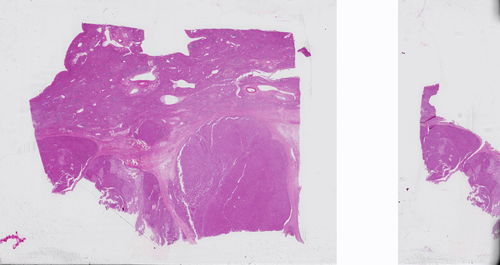

In [184]:
f.get_thumbnail((500,500))

In [190]:
# List all the qpdata annotation of Mondor series

list_qpdata = []
for roots, dirs, files in os.walk(path_slides):
    for file in files:
        if file.endswith('.qpdata'):
            list_qpdata.append(file)
            
print(len(list_qpdata)) # 11
print(list_qpdata[:3])

11
['HMNT0472_P672772_03 - 2019-11-05 01.18.44.qpdata', 'HMNT0516_P622582-05-HES.qpdata', 'HMNT1781_P705474_01_HES - 2018-11-01 10.08.24.qpdata']


In [198]:
for roots, dirs, files in os.walk('/media/visiopharm5/WDRed(backup)/qupath_mondor/data'):
    for file in files:
        if file == "server.json":
            with open(os.path.join(roots, file)) as f:
                data = json.load(f)
                print(data['metadata']['name'].split('.')[:-1])

['HMNT0071 - 2017-06-15 11', '35', '00']
['HMNT0109_bis - 2017-06-18 17', '10', '12']
['HMNT0625 - 2017-06-02 14', '03', '01']
['HMNT0625_bis - 2017-06-02 14', '38', '28']
['HMNT0723 - 2017-06-08 13', '37', '37']
['HMNT0723_bis - 2017-06-08 14', '22', '18']
['HMNT0750 - 2017-06-08 19', '38', '54']
['HMNT0820 - 2017-06-15 23', '29', '44']
['HMNT0820_bis - 2017-06-16 00', '21', '06']
['HMNT0858 - 2017-06-30 00', '02', '43']
['HMNT0858_bis - 2017-06-30 00', '56', '19']
['HMNT0869 - 2017-07-07 23', '15', '44']
['HMNT0110 - 2017-06-16 21', '50', '50']
['HMNT0869_bis - 2017-07-08 00', '03', '08']
['HMNT0972_bis - 2017-06-10 20', '03', '44']
['HMNT0981 - 2017-06-30 09', '41', '17']
['HMNT0981_bis - 2017-07-04 14', '54', '08']
['HMNT0996 - 2017-06-30 04', '50', '45']
['HMNT0996_bis - 2017-06-30 05', '53', '31']
['HMNT1383 - 2017-06-15 07', '48', '30']
['HMNT1383_bis - 2017-06-15 08', '27', '34']
['HMNT1639 - 2017-06-15 10', '22', '10']
['HMNT0182 - 2017-06-10 11', '44', '06']
['HMNT0182_bis - 

['HMNT0135_bis - 2017-06-11 15', '22', '53']
['HMNT1029_bis - 2017-07-07 20', '46', '39']
['HMNT1318 - 2017-06-10 13', '53', '45']
['HMNT1318_bis - 2017-06-10 14', '20', '53']
['HMNT1397 - 2017-06-10 09', '59', '14']
['HMNT1397_bis - 2017-06-10 10', '42', '32']
['HMNT1549 - 2017-06-18 00', '51', '18']
['HMNT1549_bis - 2017-06-18 01', '37', '18']
['HMNT1641_bis - 2017-06-18 23', '02', '49']
['HMNT1666 - 2017-06-18 09', '34', '01']
['HMNT1666_bis - 2017-06-18 10', '11', '26']
['HMNT0152 - 2017-06-08 15', '10', '14']
['HMNT1677 - 2017-06-30 03', '27', '40']
['HMNT1677_bis - 2017-06-30 04', '10', '33']
['HMNT1729 - 2017-06-29 20', '24', '14']
['HMNT1729_bis - 2017-06-29 21', '31', '01']
['HMNT1748_bis - 2017-07-08 08', '39', '07']
['HMNT1749 - 2017-07-08 09', '31', '45']
['HMNT1749_bis - 2017-07-08 10', '18', '44']
['HMNT1750 - 2017-07-08 00', '44', '16']
['HMNT1750_bis - 2017-07-08 01', '28', '19']
['HMNT0152_bis - 2017-06-08 15', '56', '31']
['HMNT2386_P761529-C01-HES']
['HMNT2410_P76442

In [199]:
for roots, dirs, files in os.walk('/media/visiopharm5/WDRed(backup)/qupath_mondor/data'):
    for file in files:
        if file == "data.qpdata":
            with open(os.path.join(roots, file)) as f:
                data = json.load(f)
                print(data)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xac in position 0: invalid start byte